# Homework 1
- Tommaso Bertola 2086990
- Giacomo Di Prima 2086992
- Giuseppe Viterbo 2086516
- Marzo Zenari 2097012

In [1]:
#DNN library
import tensorflow as tf
import keras, sklearn
from keras.models import Sequential
from keras.layers import Dense, Dropout

#common libraries
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
mpl.rc('image', cmap='copper') #global colormap 

#random seed
seed=1
np.random.seed(seed) # fix random seed

# default font
plt.rcParams['font.size'] = 15

In [2]:
%run nonlinear_function.py #here is loaded the filename, to be run only once

In [3]:
# Keras works with numpy arrays: just use them from the start
TYPE=1
x = np.loadtxt(filename("data",TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",TYPE), delimiter=' ')
N = len(x)

# dim. of a sample
L = len(x[0])
print(f'Dimension of a sample{L}')

#training percentage
perc_train = 0.8


N_train = int(perc_train * N)
print(f'data: {N}\ntrain: {N_train}')

Dimension of a sample2
data: 4000
train: 3200


In [4]:
### Split training and test data
(x_train, y_train) = (x[0:N_train],y[0:N_train]) #they are already shuffle 
(x_valid, y_valid) = (x[N_train:],y[N_train:])
print("Train:",len(x_train),"\t Validation:",len(x_valid))

Train: 3200 	 Validation: 800


In [5]:
### Rescale input data

def Rescale(x):
    return x/50 #the number goes from -50 to 50, so we put them between -1 and 1 to use the non linearity 

x_train = Rescale(x_train)
x_valid = Rescale(x_valid)

### Define the model with Keras / Tensorflow

In [6]:
def create_DNN(act_func, neurons): 
    model = Sequential() #empty template of the neural network
    model.add(Dense(L,input_shape=(L,),activation=act_func)) #add a layer dense (all connection) with a ReLu 2 neuron for 2 x_i
    model.add(Dense(units=neurons,activation=act_func))
    model.add(Dense(units=neurons,activation=act_func))
    model.add(Dense(units=neurons,activation=act_func))
    model.add(Dropout(0.01)) #it is applied to the last layer, need to be reader in keras documentation 
    model.add(Dense(1,activation='sigmoid'))
        
    return model 

### Optimization method and cost function

In [7]:
def compile_model(optimizer='adam', act_func='relu', neurons=20):
    model = create_DNN(act_func, neurons)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])    
    return model

## EX.1 Modify the Hyperparameters to Optimize Performance of the Model

In [8]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

In [9]:
# list of allowed optional arguments for the optimizer, see `compile_model()`
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adam']
act_func = ['sigmoid','tanh', 'ReLU']
batch_size = [10, 20, 30]
neurons = [20, 30]
nepochs = 8

# call Keras scikit wrapper
model_gridsearch = KerasClassifier(model=compile_model, 
                        epochs=nepochs, 
                        batch_size=batch_size,
                        act_func=act_func,
                        model__neurons=neurons,
                        verbose=2)

# define parameter dictionary
param_grid = dict(optimizer=optimizer,
                  act_func=act_func,
                  batch_size=batch_size,
                  model__neurons=neurons)

print(param_grid)


# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)

{'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adam'], 'act_func': ['sigmoid', 'tanh', 'ReLU'], 'batch_size': [10, 20, 30], 'model__neurons': [20, 30]}


In [10]:
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/8
320/320 - 1s - loss: 0.6068 - accuracy: 0.6647 - 1s/epoch - 4ms/step
Epoch 2/8
320/320 - 1s - loss: 0.5799 - accuracy: 0.6963 - 774ms/epoch - 2ms/step
Epoch 3/8
320/320 - 1s - loss: 0.5238 - accuracy: 0.7425 - 904ms/epoch - 3ms/step
Epoch 4/8
320/320 - 1s - loss: 0.4876 - accuracy: 0.7575 - 1s/epoch - 3ms/step
Epoch 5/8
320/320 - 1s - loss: 0.4769 - accuracy: 0.7591 - 724ms/epoch - 2ms/step
Epoch 6/8
320/320 - 1s - loss: 0.4706 - accuracy: 0.7656 - 936ms/epoch - 3ms/step
Epoch 7/8
320/320 - 1s - loss: 0.4659 - accuracy: 0.7669 - 1s/epoch - 4ms/step
Epoch 8/8
320/320 - 1s - loss: 0.4634 - accuracy: 0.7666 - 965ms/epoch - 3ms/step
Best: 0.838750 using {'act_func': 'tanh', 'batch_size': 10, 'model__neurons': 30, 'optimizer': 'Adam'}
0.719688 (0.013002) with: {'act_func': 'sigmoid', 'batch_size': 10, 'model__neurons': 20, 'optimizer': 'SGD'}
0.690937 (0.008855) with: {'act_func': 'sigmoid', 'batch_size': 10, 'model__neurons': 20, 'optimizer': 'RMSprop'}
0.703437 (0.036789) with: 

In [11]:
print(f'The best parameters are:{grid_result.best_params_},\nwhith a score of {grid_result.best_score_}')

The best parameters are:{'act_func': 'tanh', 'batch_size': 10, 'model__neurons': 30, 'optimizer': 'Adam'},
whith a score of 0.83875


In [12]:
nepochs=300

model = compile_model(optimizer=grid_result.best_params_['optimizer'], 
                              act_func=grid_result.best_params_['act_func'],
                              neurons=grid_result.best_params_['model__neurons'])

In [13]:
history = model.fit(x_train, y_train,
                    epochs = nepochs,
                    batch_size = grid_result.best_params_['batch_size'],
                    validation_data=(x_valid,y_valid),
                    verbose=2)

Epoch 1/300
320/320 - 2s - loss: 0.6028 - accuracy: 0.6781 - val_loss: 0.6044 - val_accuracy: 0.6862 - 2s/epoch - 6ms/step
Epoch 2/300
320/320 - 2s - loss: 0.5782 - accuracy: 0.7006 - val_loss: 0.5721 - val_accuracy: 0.7175 - 2s/epoch - 7ms/step
Epoch 3/300
320/320 - 3s - loss: 0.5338 - accuracy: 0.7394 - val_loss: 0.5156 - val_accuracy: 0.7362 - 3s/epoch - 9ms/step
Epoch 4/300
320/320 - 2s - loss: 0.4980 - accuracy: 0.7609 - val_loss: 0.5129 - val_accuracy: 0.7675 - 2s/epoch - 7ms/step
Epoch 5/300
320/320 - 1s - loss: 0.4794 - accuracy: 0.7759 - val_loss: 0.4784 - val_accuracy: 0.7738 - 1s/epoch - 4ms/step
Epoch 6/300
320/320 - 1s - loss: 0.4510 - accuracy: 0.8022 - val_loss: 0.4478 - val_accuracy: 0.8062 - 1s/epoch - 4ms/step
Epoch 7/300
320/320 - 1s - loss: 0.4092 - accuracy: 0.8231 - val_loss: 0.3931 - val_accuracy: 0.8238 - 969ms/epoch - 3ms/step
Epoch 8/300
320/320 - 1s - loss: 0.3791 - accuracy: 0.8313 - val_loss: 0.3582 - val_accuracy: 0.8400 - 903ms/epoch - 3ms/step
Epoch 9/30

Epoch 67/300
320/320 - 2s - loss: 0.0793 - accuracy: 0.9688 - val_loss: 0.0683 - val_accuracy: 0.9712 - 2s/epoch - 5ms/step
Epoch 68/300
320/320 - 2s - loss: 0.0752 - accuracy: 0.9712 - val_loss: 0.1070 - val_accuracy: 0.9563 - 2s/epoch - 5ms/step
Epoch 69/300
320/320 - 1s - loss: 0.0819 - accuracy: 0.9669 - val_loss: 0.0739 - val_accuracy: 0.9737 - 1s/epoch - 4ms/step
Epoch 70/300
320/320 - 1s - loss: 0.0787 - accuracy: 0.9700 - val_loss: 0.0517 - val_accuracy: 0.9875 - 1s/epoch - 4ms/step
Epoch 71/300
320/320 - 2s - loss: 0.0796 - accuracy: 0.9684 - val_loss: 0.0606 - val_accuracy: 0.9775 - 2s/epoch - 5ms/step
Epoch 72/300
320/320 - 1s - loss: 0.0775 - accuracy: 0.9675 - val_loss: 0.0550 - val_accuracy: 0.9825 - 1s/epoch - 4ms/step
Epoch 73/300
320/320 - 1s - loss: 0.0777 - accuracy: 0.9709 - val_loss: 0.1085 - val_accuracy: 0.9525 - 1s/epoch - 3ms/step
Epoch 74/300
320/320 - 1s - loss: 0.0805 - accuracy: 0.9672 - val_loss: 0.0616 - val_accuracy: 0.9675 - 895ms/epoch - 3ms/step
Epoch

Epoch 133/300
320/320 - 1s - loss: 0.0596 - accuracy: 0.9734 - val_loss: 0.0361 - val_accuracy: 0.9887 - 1s/epoch - 3ms/step
Epoch 134/300
320/320 - 4s - loss: 0.0753 - accuracy: 0.9666 - val_loss: 0.0367 - val_accuracy: 0.9875 - 4s/epoch - 12ms/step
Epoch 135/300
320/320 - 3s - loss: 0.0632 - accuracy: 0.9719 - val_loss: 0.0419 - val_accuracy: 0.9837 - 3s/epoch - 9ms/step
Epoch 136/300
320/320 - 2s - loss: 0.0655 - accuracy: 0.9716 - val_loss: 0.0955 - val_accuracy: 0.9600 - 2s/epoch - 6ms/step
Epoch 137/300
320/320 - 1s - loss: 0.0553 - accuracy: 0.9797 - val_loss: 0.0720 - val_accuracy: 0.9638 - 1s/epoch - 4ms/step
Epoch 138/300
320/320 - 2s - loss: 0.0645 - accuracy: 0.9731 - val_loss: 0.0351 - val_accuracy: 0.9825 - 2s/epoch - 5ms/step
Epoch 139/300
320/320 - 1s - loss: 0.0610 - accuracy: 0.9766 - val_loss: 0.1219 - val_accuracy: 0.9563 - 1s/epoch - 4ms/step
Epoch 140/300
320/320 - 1s - loss: 0.0621 - accuracy: 0.9700 - val_loss: 0.0676 - val_accuracy: 0.9725 - 1s/epoch - 4ms/step

Epoch 199/300
320/320 - 1s - loss: 0.0533 - accuracy: 0.9756 - val_loss: 0.0329 - val_accuracy: 0.9887 - 1s/epoch - 4ms/step
Epoch 200/300
320/320 - 1s - loss: 0.0564 - accuracy: 0.9759 - val_loss: 0.0383 - val_accuracy: 0.9825 - 1s/epoch - 3ms/step
Epoch 201/300
320/320 - 1s - loss: 0.0478 - accuracy: 0.9794 - val_loss: 0.0480 - val_accuracy: 0.9775 - 1s/epoch - 4ms/step
Epoch 202/300
320/320 - 1s - loss: 0.0562 - accuracy: 0.9778 - val_loss: 0.0493 - val_accuracy: 0.9787 - 987ms/epoch - 3ms/step
Epoch 203/300
320/320 - 1s - loss: 0.0528 - accuracy: 0.9791 - val_loss: 0.0721 - val_accuracy: 0.9625 - 1s/epoch - 4ms/step
Epoch 204/300
320/320 - 1s - loss: 0.0513 - accuracy: 0.9772 - val_loss: 0.0492 - val_accuracy: 0.9800 - 1s/epoch - 3ms/step
Epoch 205/300
320/320 - 1s - loss: 0.0482 - accuracy: 0.9787 - val_loss: 0.0441 - val_accuracy: 0.9775 - 979ms/epoch - 3ms/step
Epoch 206/300
320/320 - 1s - loss: 0.0563 - accuracy: 0.9756 - val_loss: 0.0457 - val_accuracy: 0.9800 - 1s/epoch - 4ms

Epoch 264/300
320/320 - 1s - loss: 0.0447 - accuracy: 0.9809 - val_loss: 0.0427 - val_accuracy: 0.9787 - 877ms/epoch - 3ms/step
Epoch 265/300
320/320 - 1s - loss: 0.0456 - accuracy: 0.9816 - val_loss: 0.0325 - val_accuracy: 0.9862 - 1s/epoch - 4ms/step
Epoch 266/300
320/320 - 1s - loss: 0.0449 - accuracy: 0.9797 - val_loss: 0.0287 - val_accuracy: 0.9850 - 903ms/epoch - 3ms/step
Epoch 267/300
320/320 - 1s - loss: 0.0528 - accuracy: 0.9784 - val_loss: 0.0437 - val_accuracy: 0.9875 - 926ms/epoch - 3ms/step
Epoch 268/300
320/320 - 1s - loss: 0.0430 - accuracy: 0.9787 - val_loss: 0.0399 - val_accuracy: 0.9837 - 823ms/epoch - 3ms/step
Epoch 269/300
320/320 - 1s - loss: 0.0515 - accuracy: 0.9791 - val_loss: 0.0419 - val_accuracy: 0.9800 - 1s/epoch - 3ms/step
Epoch 270/300
320/320 - 1s - loss: 0.0562 - accuracy: 0.9769 - val_loss: 0.0294 - val_accuracy: 0.9887 - 1s/epoch - 3ms/step
Epoch 271/300
320/320 - 1s - loss: 0.0388 - accuracy: 0.9834 - val_loss: 0.0320 - val_accuracy: 0.9862 - 987ms/ep

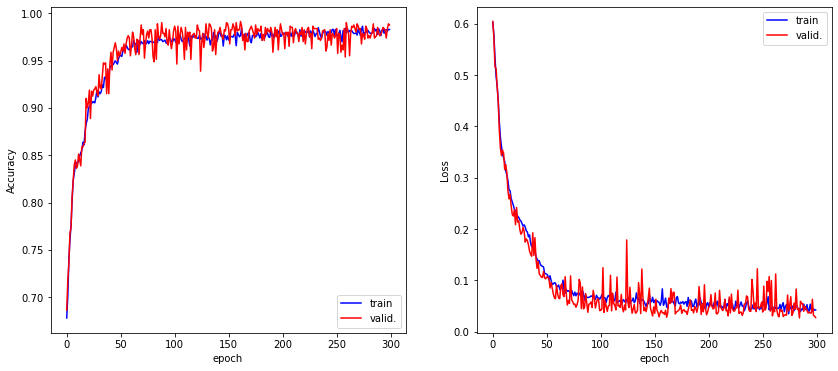

In [14]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(history.history['accuracy'],label="train",c="b")
ax.plot(history.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()
ax=AX[1]
ax.plot(history.history['loss'],label="train",c="b")
ax.plot(history.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

51 2601
[50. 50.]
82/82 [==============================] - 0s 2ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

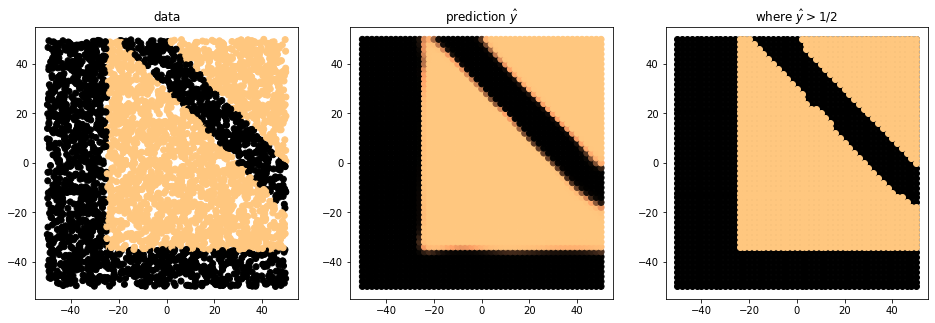

In [15]:
dX = 2
X1 = np.arange(-50,50+dX, dX)
LG = len(X1)
grid = np.zeros((LG*LG,2))
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1
print(len(X1),len(grid))
print(grid[-1])

# RESCALE

grid_r = grid/50

pred = model.predict(grid_r)

fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y)
ax.set_title("data")

ax=AX[1]
ax.scatter(grid[:,0],grid[:,1],c=pred)
ax.set_title("prediction $\\hat y$")

ax=AX[2]
W1=np.where(pred>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],c="#000000")
ax.scatter(grid[W1,0],grid[W1,1],c="#ffc77f")
ax.set_title("where $\\hat y > 1/2$")
plt.show
plt.show

## Ex.2 Change the number of sample 

### Reduced number of sample

In [16]:
x = np.loadtxt(filename("data",TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",TYPE), delimiter=' ')

red_val=0.6
(x, y) = (x[:int(red_val*len(x))], y[:int(red_val*len(x))])

N=len(x)
perc_train=0.8
N_train = int(N*perc_train)

(x_train, y_train) = (x[0:N_train],y[0:N_train]) #they are already shuffle 
(x_valid, y_valid) = (x[N_train:],y[N_train:])
print("Train:",len(x_train),"\t Validation:",len(x_valid))

Train: 1920 	 Validation: 480


In [17]:
#optimization
nepochs=300
model_reduced = compile_model(optimizer=grid_result.best_params_['optimizer'], 
                              act_func=grid_result.best_params_['act_func'],
                              neurons=grid_result.best_params_['model__neurons'])

In [18]:
history_reduced = model_reduced.fit(x_train, y_train,
                                    epochs = nepochs,
                                    batch_size = grid_result.best_params_['batch_size'],
                                    validation_data=(x_valid,y_valid),
                                    verbose=1)

Epoch 1/300
192/192 [==============================] - 1s 5ms/step - loss: 0.6461 - accuracy: 0.6542 - val_loss: 0.6268 - val_accuracy: 0.6833
Epoch 2/300
192/192 [==============================] - 1s 4ms/step - loss: 0.6359 - accuracy: 0.6667 - val_loss: 0.6255 - val_accuracy: 0.6854
Epoch 3/300
192/192 [==============================] - 1s 4ms/step - loss: 0.6348 - accuracy: 0.6687 - val_loss: 0.6254 - val_accuracy: 0.6812
Epoch 4/300
192/192 [==============================] - 1s 4ms/step - loss: 0.6317 - accuracy: 0.6667 - val_loss: 0.6286 - val_accuracy: 0.6729
Epoch 5/300
192/192 [==============================] - 1s 4ms/step - loss: 0.6315 - accuracy: 0.6677 - val_loss: 0.6307 - val_accuracy: 0.6729
Epoch 6/300
192/192 [==============================] - 1s 3ms/step - loss: 0.6285 - accuracy: 0.6677 - val_loss: 0.6305 - val_accuracy: 0.6729
Epoch 7/300
192/192 [==============================] - 1s 4ms/step - loss: 0.6300 - accuracy: 0.6682 - val_loss: 0.6318 - val_accuracy: 0.6729

Epoch 58/300
192/192 [==============================] - 1s 4ms/step - loss: 0.6185 - accuracy: 0.6698 - val_loss: 0.6276 - val_accuracy: 0.6792
Epoch 59/300
192/192 [==============================] - 1s 4ms/step - loss: 0.6198 - accuracy: 0.6708 - val_loss: 0.6249 - val_accuracy: 0.6771
Epoch 60/300
192/192 [==============================] - 1s 4ms/step - loss: 0.6196 - accuracy: 0.6682 - val_loss: 0.6253 - val_accuracy: 0.6729
Epoch 61/300
192/192 [==============================] - 1s 5ms/step - loss: 0.6199 - accuracy: 0.6693 - val_loss: 0.6249 - val_accuracy: 0.6771
Epoch 62/300
192/192 [==============================] - 1s 4ms/step - loss: 0.6197 - accuracy: 0.6687 - val_loss: 0.6270 - val_accuracy: 0.6750
Epoch 63/300
192/192 [==============================] - 1s 5ms/step - loss: 0.6197 - accuracy: 0.6687 - val_loss: 0.6256 - val_accuracy: 0.6771
Epoch 64/300
192/192 [==============================] - 1s 4ms/step - loss: 0.6187 - accuracy: 0.6708 - val_loss: 0.6252 - val_accuracy:

Epoch 115/300
192/192 [==============================] - 1s 5ms/step - loss: 0.6173 - accuracy: 0.6708 - val_loss: 0.6224 - val_accuracy: 0.6708
Epoch 116/300
192/192 [==============================] - 1s 5ms/step - loss: 0.6170 - accuracy: 0.6719 - val_loss: 0.6232 - val_accuracy: 0.6708
Epoch 117/300
192/192 [==============================] - 1s 5ms/step - loss: 0.6169 - accuracy: 0.6729 - val_loss: 0.6215 - val_accuracy: 0.6750
Epoch 118/300
192/192 [==============================] - 1s 4ms/step - loss: 0.6169 - accuracy: 0.6719 - val_loss: 0.6235 - val_accuracy: 0.6729
Epoch 119/300
192/192 [==============================] - 2s 8ms/step - loss: 0.6168 - accuracy: 0.6708 - val_loss: 0.6223 - val_accuracy: 0.6729
Epoch 120/300
192/192 [==============================] - 2s 8ms/step - loss: 0.6162 - accuracy: 0.6708 - val_loss: 0.6236 - val_accuracy: 0.6729
Epoch 121/300
192/192 [==============================] - 1s 7ms/step - loss: 0.6159 - accuracy: 0.6708 - val_loss: 0.6213 - val_ac

192/192 [==============================] - 1s 4ms/step - loss: 0.6125 - accuracy: 0.6745 - val_loss: 0.6194 - val_accuracy: 0.6729
Epoch 172/300
192/192 [==============================] - 1s 4ms/step - loss: 0.6121 - accuracy: 0.6719 - val_loss: 0.6183 - val_accuracy: 0.6771
Epoch 173/300
192/192 [==============================] - 1s 4ms/step - loss: 0.6116 - accuracy: 0.6734 - val_loss: 0.6171 - val_accuracy: 0.6771
Epoch 174/300
192/192 [==============================] - 1s 4ms/step - loss: 0.6117 - accuracy: 0.6729 - val_loss: 0.6176 - val_accuracy: 0.6750
Epoch 175/300
192/192 [==============================] - 1s 5ms/step - loss: 0.6109 - accuracy: 0.6755 - val_loss: 0.6164 - val_accuracy: 0.6750
Epoch 176/300
192/192 [==============================] - 1s 5ms/step - loss: 0.6124 - accuracy: 0.6750 - val_loss: 0.6178 - val_accuracy: 0.6729
Epoch 177/300
192/192 [==============================] - 1s 4ms/step - loss: 0.6121 - accuracy: 0.6724 - val_loss: 0.6158 - val_accuracy: 0.6771

192/192 [==============================] - 1s 4ms/step - loss: 0.5858 - accuracy: 0.6766 - val_loss: 0.5683 - val_accuracy: 0.7000
Epoch 228/300
192/192 [==============================] - 1s 4ms/step - loss: 0.5856 - accuracy: 0.6766 - val_loss: 0.5671 - val_accuracy: 0.7000
Epoch 229/300
192/192 [==============================] - 1s 4ms/step - loss: 0.5863 - accuracy: 0.6750 - val_loss: 0.5688 - val_accuracy: 0.7021
Epoch 230/300
192/192 [==============================] - 1s 4ms/step - loss: 0.5856 - accuracy: 0.6740 - val_loss: 0.5765 - val_accuracy: 0.6417
Epoch 231/300
192/192 [==============================] - 1s 4ms/step - loss: 0.5853 - accuracy: 0.6646 - val_loss: 0.5615 - val_accuracy: 0.7021
Epoch 232/300
192/192 [==============================] - 1s 4ms/step - loss: 0.5879 - accuracy: 0.6661 - val_loss: 0.5650 - val_accuracy: 0.7042
Epoch 233/300
192/192 [==============================] - 1s 4ms/step - loss: 0.5875 - accuracy: 0.6677 - val_loss: 0.5609 - val_accuracy: 0.7021

192/192 [==============================] - 1s 5ms/step - loss: 0.5764 - accuracy: 0.6891 - val_loss: 0.5575 - val_accuracy: 0.7021
Epoch 284/300
192/192 [==============================] - 1s 5ms/step - loss: 0.5801 - accuracy: 0.6911 - val_loss: 0.5599 - val_accuracy: 0.7000
Epoch 285/300
192/192 [==============================] - 1s 3ms/step - loss: 0.5788 - accuracy: 0.6880 - val_loss: 0.5636 - val_accuracy: 0.7021
Epoch 286/300
192/192 [==============================] - 1s 4ms/step - loss: 0.5780 - accuracy: 0.6875 - val_loss: 0.5602 - val_accuracy: 0.7083
Epoch 287/300
192/192 [==============================] - 1s 5ms/step - loss: 0.5770 - accuracy: 0.6901 - val_loss: 0.5564 - val_accuracy: 0.7042
Epoch 288/300
192/192 [==============================] - 1s 4ms/step - loss: 0.5776 - accuracy: 0.6891 - val_loss: 0.5695 - val_accuracy: 0.6979
Epoch 289/300
192/192 [==============================] - 1s 5ms/step - loss: 0.5813 - accuracy: 0.6865 - val_loss: 0.5558 - val_accuracy: 0.7021

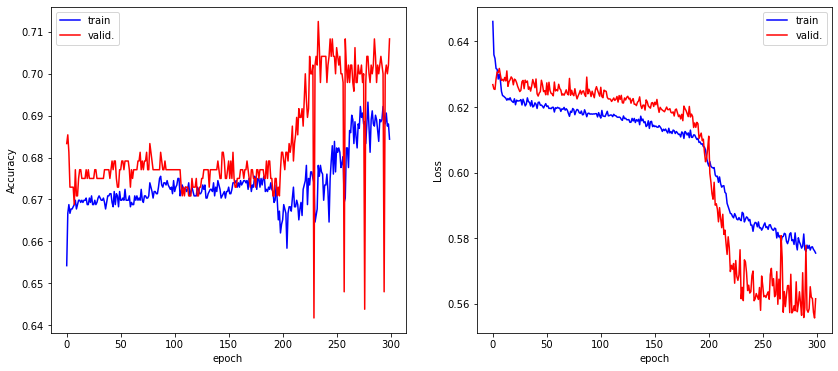

In [19]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(history_reduced.history['accuracy'],label="train",c="b")
ax.plot(history_reduced.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()
ax=AX[1]
ax.plot(history_reduced.history['loss'],label="train",c="b")
ax.plot(history_reduced.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

51 2601
[50. 50.]
82/82 [==============================] - 0s 3ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

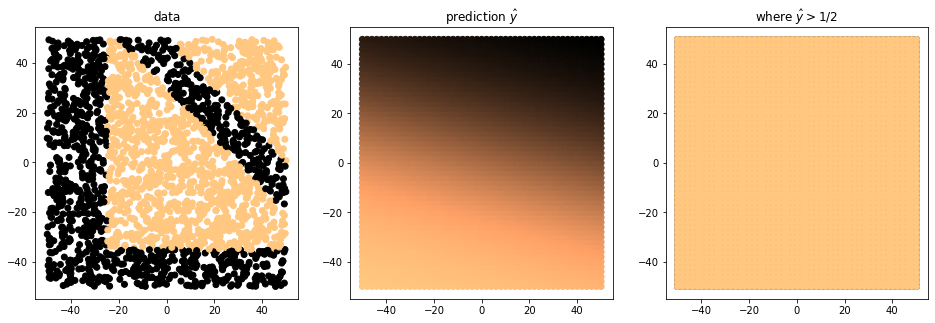

In [20]:
dX = 2
X1 = np.arange(-50,50+dX, dX)
LG = len(X1)
grid = np.zeros((LG*LG,2))
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1
print(len(X1),len(grid))
print(grid[-1])

# RESCALE

grid_r = grid/50

pred = model_reduced.predict(grid_r)

fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y)
ax.set_title("data")

ax=AX[1]
ax.scatter(grid[:,0],grid[:,1],c=pred)
ax.set_title("prediction $\\hat y$")

ax=AX[2]
W1=np.where(pred>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],c="#000000")
ax.scatter(grid[W1,0],grid[W1,1],c="#ffc77f")
ax.set_title("where $\\hat y > 1/2$")
plt.show
plt.show

### Increased number of sample
We generated two additional file where the numeber of sample is 6000 using the same generate_data_DNN_2023 notebook. 

In [21]:
x = np.loadtxt(filename("data_increased",TYPE), delimiter=' ')
y = np.loadtxt(filename("labels_increased",TYPE), delimiter=' ')

N=len(x)
perc_train=0.8
N_train = int(N*perc_train)

(x_train, y_train) = (x[0:N_train],y[0:N_train]) #they are already shuffle 
(x_valid, y_valid) = (x[N_train:],y[N_train:])
print("Train:",len(x_train),"\t Validation:",len(x_valid))

Train: 4800 	 Validation: 1200


In [22]:
#optimization
nepochs=300
model_increased = compile_model(optimizer=grid_result.best_params_['optimizer'], 
                              act_func=grid_result.best_params_['act_func'],
                              neurons=grid_result.best_params_['model__neurons'])

In [23]:
history_increased = model_increased.fit(x_train, y_train,
                                    epochs = nepochs,
                                    batch_size = grid_result.best_params_['batch_size'],
                                    validation_data=(x_valid,y_valid),
                                    verbose=1)

Epoch 1/300
480/480 [==============================] - 3s 5ms/step - loss: 0.6648 - accuracy: 0.5954 - val_loss: 0.6441 - val_accuracy: 0.6308
Epoch 2/300
480/480 [==============================] - 2s 4ms/step - loss: 0.6538 - accuracy: 0.6175 - val_loss: 0.6426 - val_accuracy: 0.6350
Epoch 3/300
480/480 [==============================] - 2s 4ms/step - loss: 0.6527 - accuracy: 0.6217 - val_loss: 0.6417 - val_accuracy: 0.6383
Epoch 4/300
480/480 [==============================] - 2s 4ms/step - loss: 0.6514 - accuracy: 0.6260 - val_loss: 0.6429 - val_accuracy: 0.6417
Epoch 5/300
480/480 [==============================] - 2s 4ms/step - loss: 0.6502 - accuracy: 0.6285 - val_loss: 0.6390 - val_accuracy: 0.6408
Epoch 6/300
480/480 [==============================] - 2s 4ms/step - loss: 0.6502 - accuracy: 0.6283 - val_loss: 0.6395 - val_accuracy: 0.6433
Epoch 7/300
480/480 [==============================] - 2s 4ms/step - loss: 0.6481 - accuracy: 0.6327 - val_loss: 0.6491 - val_accuracy: 0.6467

Epoch 58/300
480/480 [==============================] - 2s 3ms/step - loss: 0.4317 - accuracy: 0.7860 - val_loss: 0.4317 - val_accuracy: 0.7900
Epoch 59/300
480/480 [==============================] - 2s 5ms/step - loss: 0.4254 - accuracy: 0.7915 - val_loss: 0.4415 - val_accuracy: 0.7858
Epoch 60/300
480/480 [==============================] - 4s 8ms/step - loss: 0.4222 - accuracy: 0.7917 - val_loss: 0.4239 - val_accuracy: 0.7975
Epoch 61/300
480/480 [==============================] - 2s 4ms/step - loss: 0.4281 - accuracy: 0.7931 - val_loss: 0.4283 - val_accuracy: 0.7917
Epoch 62/300
480/480 [==============================] - 3s 6ms/step - loss: 0.4214 - accuracy: 0.7965 - val_loss: 0.4420 - val_accuracy: 0.7833
Epoch 63/300
480/480 [==============================] - 3s 7ms/step - loss: 0.4172 - accuracy: 0.7960 - val_loss: 0.4386 - val_accuracy: 0.7892
Epoch 64/300
480/480 [==============================] - 2s 5ms/step - loss: 0.4209 - accuracy: 0.7971 - val_loss: 0.4309 - val_accuracy:

Epoch 115/300
480/480 [==============================] - 2s 4ms/step - loss: 0.2912 - accuracy: 0.8700 - val_loss: 0.2973 - val_accuracy: 0.8650
Epoch 116/300
480/480 [==============================] - 2s 4ms/step - loss: 0.2853 - accuracy: 0.8704 - val_loss: 0.2957 - val_accuracy: 0.8592
Epoch 117/300
480/480 [==============================] - 2s 4ms/step - loss: 0.2844 - accuracy: 0.8737 - val_loss: 0.3097 - val_accuracy: 0.8608
Epoch 118/300
480/480 [==============================] - 2s 4ms/step - loss: 0.2877 - accuracy: 0.8704 - val_loss: 0.2993 - val_accuracy: 0.8625
Epoch 119/300
480/480 [==============================] - 2s 4ms/step - loss: 0.2881 - accuracy: 0.8704 - val_loss: 0.2904 - val_accuracy: 0.8650
Epoch 120/300
480/480 [==============================] - 2s 4ms/step - loss: 0.2866 - accuracy: 0.8731 - val_loss: 0.3190 - val_accuracy: 0.8592
Epoch 121/300
480/480 [==============================] - 2s 3ms/step - loss: 0.2859 - accuracy: 0.8723 - val_loss: 0.3108 - val_ac

480/480 [==============================] - 2s 4ms/step - loss: 0.2846 - accuracy: 0.8717 - val_loss: 0.2902 - val_accuracy: 0.8650
Epoch 172/300
480/480 [==============================] - 2s 3ms/step - loss: 0.2824 - accuracy: 0.8710 - val_loss: 0.2938 - val_accuracy: 0.8592
Epoch 173/300
480/480 [==============================] - 2s 4ms/step - loss: 0.2839 - accuracy: 0.8721 - val_loss: 0.3519 - val_accuracy: 0.8625
Epoch 174/300
480/480 [==============================] - 2s 3ms/step - loss: 0.2834 - accuracy: 0.8721 - val_loss: 0.3003 - val_accuracy: 0.8542
Epoch 175/300
480/480 [==============================] - 2s 4ms/step - loss: 0.2841 - accuracy: 0.8715 - val_loss: 0.2968 - val_accuracy: 0.8625
Epoch 176/300
480/480 [==============================] - 2s 3ms/step - loss: 0.2848 - accuracy: 0.8723 - val_loss: 0.2838 - val_accuracy: 0.8667
Epoch 177/300
480/480 [==============================] - 2s 3ms/step - loss: 0.2855 - accuracy: 0.8702 - val_loss: 0.2953 - val_accuracy: 0.8642

480/480 [==============================] - 2s 3ms/step - loss: 0.2866 - accuracy: 0.8698 - val_loss: 0.2873 - val_accuracy: 0.8617
Epoch 228/300
480/480 [==============================] - 2s 5ms/step - loss: 0.2843 - accuracy: 0.8717 - val_loss: 0.2942 - val_accuracy: 0.8608
Epoch 229/300
480/480 [==============================] - 2s 4ms/step - loss: 0.2806 - accuracy: 0.8710 - val_loss: 0.2884 - val_accuracy: 0.8625
Epoch 230/300
480/480 [==============================] - 2s 4ms/step - loss: 0.2781 - accuracy: 0.8721 - val_loss: 0.2835 - val_accuracy: 0.8642
Epoch 231/300
480/480 [==============================] - 2s 3ms/step - loss: 0.2864 - accuracy: 0.8702 - val_loss: 0.2836 - val_accuracy: 0.8650
Epoch 232/300
480/480 [==============================] - 2s 4ms/step - loss: 0.2825 - accuracy: 0.8710 - val_loss: 0.2925 - val_accuracy: 0.8583
Epoch 233/300
480/480 [==============================] - 2s 3ms/step - loss: 0.2795 - accuracy: 0.8725 - val_loss: 0.2883 - val_accuracy: 0.8633

480/480 [==============================] - 2s 4ms/step - loss: 0.2802 - accuracy: 0.8719 - val_loss: 0.2959 - val_accuracy: 0.8617
Epoch 284/300
480/480 [==============================] - 2s 4ms/step - loss: 0.2787 - accuracy: 0.8727 - val_loss: 0.3345 - val_accuracy: 0.8450
Epoch 285/300
480/480 [==============================] - 2s 4ms/step - loss: 0.2829 - accuracy: 0.8694 - val_loss: 0.2858 - val_accuracy: 0.8633
Epoch 286/300
480/480 [==============================] - 2s 4ms/step - loss: 0.2793 - accuracy: 0.8712 - val_loss: 0.3243 - val_accuracy: 0.8550
Epoch 287/300
480/480 [==============================] - 2s 4ms/step - loss: 0.2811 - accuracy: 0.8723 - val_loss: 0.3106 - val_accuracy: 0.8508
Epoch 288/300
480/480 [==============================] - 2s 4ms/step - loss: 0.2854 - accuracy: 0.8694 - val_loss: 0.2880 - val_accuracy: 0.8617
Epoch 289/300
480/480 [==============================] - 2s 4ms/step - loss: 0.2784 - accuracy: 0.8717 - val_loss: 0.2841 - val_accuracy: 0.8625

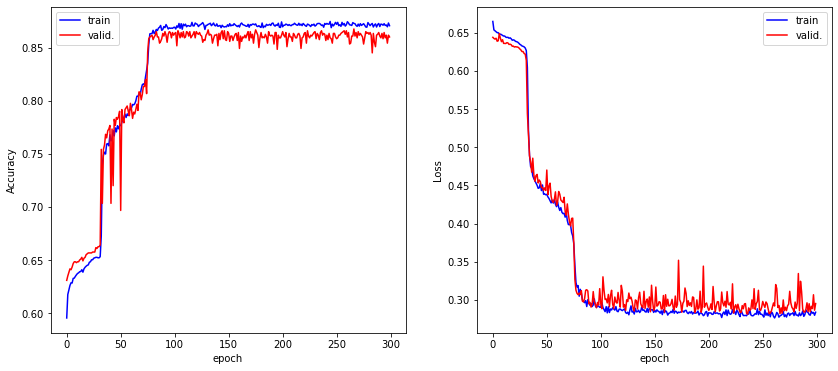

In [24]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(history_increased.history['accuracy'],label="train",c="b")
ax.plot(history_increased.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()
ax=AX[1]
ax.plot(history_increased.history['loss'],label="train",c="b")
ax.plot(history_increased.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

51 2601
[50. 50.]
82/82 [==============================] - 0s 2ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

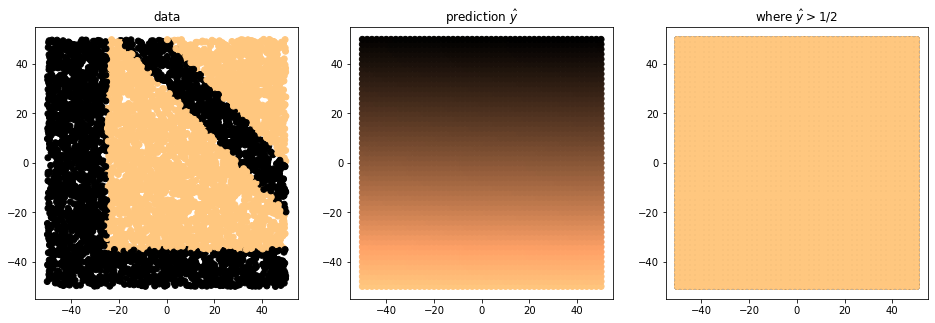

In [25]:
dX = 2
X1 = np.arange(-50,50+dX, dX)
LG = len(X1)
grid = np.zeros((LG*LG,2))
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1
print(len(X1),len(grid))
print(grid[-1])

# RESCALE

grid_r = grid/50

pred = model_increased.predict(grid_r)

fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y)
ax.set_title("data")

ax=AX[1]
ax.scatter(grid[:,0],grid[:,1],c=pred)
ax.set_title("prediction $\\hat y$")

ax=AX[2]
W1=np.where(pred>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],c="#000000")
ax.scatter(grid[W1,0],grid[W1,1],c="#ffc77f")
ax.set_title("where $\\hat y > 1/2$")
plt.show
plt.show

### Augmented number of sample

We decided to not augment the validation set since we want to obtain an accurate estimation of the error and adding artificial data would compromise the logic behind this validation procedure.    

In [26]:
TYPE=1
x = np.loadtxt(filename("data",TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",TYPE), delimiter=' ')

N=len(x)
perc_train=0.8
N_train = int(N*perc_train)

(x_train, y_train) = (x[0:N_train],y[0:N_train]) #they are already shuffle 
(x_valid, y_valid) = (x[N_train:],y[N_train:])
print("Train:",len(x_train),"\t Validation:",len(x_valid))

x_aug = x_train + np.random.normal(0, 0.05, size=x_train.shape)
y_aug = np.copy(y_train)

x_train = np.vstack((x_train, x_aug))
y_train = np.hstack((y_train, y_aug))
print('After augmentation')
print("Train:",len(x_train),"\t Validation:",len(x_valid))

Train: 3200 	 Validation: 800
After augmentation
Train: 6400 	 Validation: 800


In [27]:
#optimization
nepochs=300
model_augmented = compile_model(optimizer=grid_result.best_params_['optimizer'], 
                              act_func=grid_result.best_params_['act_func'],
                              neurons=grid_result.best_params_['model__neurons'])

In [28]:
history_augmented = model_augmented.fit(x_train, y_train,
                                      epochs = nepochs,
                                      batch_size = grid_result.best_params_['batch_size'],
                                      validation_data=(x_valid,y_valid),
                                      verbose=1)

Epoch 1/300
640/640 [==============================] - 3s 4ms/step - loss: 0.6319 - accuracy: 0.6705 - val_loss: 0.6362 - val_accuracy: 0.6750
Epoch 2/300
640/640 [==============================] - 3s 4ms/step - loss: 0.6188 - accuracy: 0.6855 - val_loss: 0.6208 - val_accuracy: 0.6888
Epoch 3/300
640/640 [==============================] - 2s 4ms/step - loss: 0.5853 - accuracy: 0.7197 - val_loss: 0.5565 - val_accuracy: 0.7275
Epoch 4/300
640/640 [==============================] - 2s 4ms/step - loss: 0.4998 - accuracy: 0.7556 - val_loss: 0.4686 - val_accuracy: 0.7725
Epoch 5/300
640/640 [==============================] - 3s 5ms/step - loss: 0.4814 - accuracy: 0.7575 - val_loss: 0.4623 - val_accuracy: 0.7638
Epoch 6/300
640/640 [==============================] - 3s 5ms/step - loss: 0.4723 - accuracy: 0.7611 - val_loss: 0.4628 - val_accuracy: 0.7625
Epoch 7/300
640/640 [==============================] - 4s 6ms/step - loss: 0.4684 - accuracy: 0.7581 - val_loss: 0.4672 - val_accuracy: 0.7638

Epoch 58/300
640/640 [==============================] - 4s 6ms/step - loss: 0.4218 - accuracy: 0.8042 - val_loss: 0.4098 - val_accuracy: 0.8263
Epoch 59/300
640/640 [==============================] - 3s 5ms/step - loss: 0.3731 - accuracy: 0.8436 - val_loss: 0.3433 - val_accuracy: 0.8662
Epoch 60/300
640/640 [==============================] - 2s 4ms/step - loss: 0.3290 - accuracy: 0.8678 - val_loss: 0.3136 - val_accuracy: 0.8725
Epoch 61/300
640/640 [==============================] - 3s 4ms/step - loss: 0.3223 - accuracy: 0.8697 - val_loss: 0.3852 - val_accuracy: 0.8512
Epoch 62/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3222 - accuracy: 0.8695 - val_loss: 0.3102 - val_accuracy: 0.8700
Epoch 63/300
640/640 [==============================] - 2s 4ms/step - loss: 0.3150 - accuracy: 0.8722 - val_loss: 0.3198 - val_accuracy: 0.8612
Epoch 64/300
640/640 [==============================] - 3s 5ms/step - loss: 0.3185 - accuracy: 0.8703 - val_loss: 0.3412 - val_accuracy:

Epoch 115/300
640/640 [==============================] - 2s 4ms/step - loss: 0.2955 - accuracy: 0.8708 - val_loss: 0.3173 - val_accuracy: 0.8637
Epoch 116/300
640/640 [==============================] - 3s 4ms/step - loss: 0.2976 - accuracy: 0.8711 - val_loss: 0.3260 - val_accuracy: 0.8525
Epoch 117/300
640/640 [==============================] - 2s 3ms/step - loss: 0.2944 - accuracy: 0.8728 - val_loss: 0.3021 - val_accuracy: 0.8687
Epoch 118/300
640/640 [==============================] - 2s 4ms/step - loss: 0.2994 - accuracy: 0.8705 - val_loss: 0.3014 - val_accuracy: 0.8675
Epoch 119/300
640/640 [==============================] - 2s 4ms/step - loss: 0.2947 - accuracy: 0.8730 - val_loss: 0.2939 - val_accuracy: 0.8687
Epoch 120/300
640/640 [==============================] - 2s 4ms/step - loss: 0.2972 - accuracy: 0.8703 - val_loss: 0.3004 - val_accuracy: 0.8650
Epoch 121/300
640/640 [==============================] - 2s 3ms/step - loss: 0.2927 - accuracy: 0.8719 - val_loss: 0.3338 - val_ac

640/640 [==============================] - 2s 3ms/step - loss: 0.2888 - accuracy: 0.8728 - val_loss: 0.3051 - val_accuracy: 0.8612
Epoch 172/300
640/640 [==============================] - 2s 3ms/step - loss: 0.2865 - accuracy: 0.8741 - val_loss: 0.3371 - val_accuracy: 0.8462
Epoch 173/300
640/640 [==============================] - 2s 4ms/step - loss: 0.2915 - accuracy: 0.8722 - val_loss: 0.3218 - val_accuracy: 0.8575
Epoch 174/300
640/640 [==============================] - 2s 4ms/step - loss: 0.2886 - accuracy: 0.8723 - val_loss: 0.3304 - val_accuracy: 0.8475
Epoch 175/300
640/640 [==============================] - 2s 3ms/step - loss: 0.2924 - accuracy: 0.8706 - val_loss: 0.3136 - val_accuracy: 0.8600
Epoch 176/300
640/640 [==============================] - 2s 4ms/step - loss: 0.2888 - accuracy: 0.8706 - val_loss: 0.2955 - val_accuracy: 0.8650
Epoch 177/300
640/640 [==============================] - 2s 4ms/step - loss: 0.2890 - accuracy: 0.8716 - val_loss: 0.3163 - val_accuracy: 0.8562

640/640 [==============================] - 3s 5ms/step - loss: 0.2872 - accuracy: 0.8717 - val_loss: 0.3455 - val_accuracy: 0.8438
Epoch 228/300
640/640 [==============================] - 3s 5ms/step - loss: 0.2883 - accuracy: 0.8736 - val_loss: 0.2909 - val_accuracy: 0.8675
Epoch 229/300
640/640 [==============================] - 3s 5ms/step - loss: 0.2885 - accuracy: 0.8716 - val_loss: 0.3174 - val_accuracy: 0.8537
Epoch 230/300
640/640 [==============================] - 3s 5ms/step - loss: 0.2875 - accuracy: 0.8728 - val_loss: 0.3616 - val_accuracy: 0.8512
Epoch 231/300
640/640 [==============================] - 3s 5ms/step - loss: 0.2884 - accuracy: 0.8725 - val_loss: 0.3584 - val_accuracy: 0.8550
Epoch 232/300
640/640 [==============================] - 3s 5ms/step - loss: 0.2865 - accuracy: 0.8728 - val_loss: 0.3109 - val_accuracy: 0.8562
Epoch 233/300
640/640 [==============================] - 3s 5ms/step - loss: 0.2907 - accuracy: 0.8719 - val_loss: 0.2935 - val_accuracy: 0.8650

640/640 [==============================] - 2s 3ms/step - loss: 0.2882 - accuracy: 0.8737 - val_loss: 0.3350 - val_accuracy: 0.8487
Epoch 284/300
640/640 [==============================] - 2s 3ms/step - loss: 0.2891 - accuracy: 0.8708 - val_loss: 0.2973 - val_accuracy: 0.8587
Epoch 285/300
640/640 [==============================] - 2s 4ms/step - loss: 0.2913 - accuracy: 0.8723 - val_loss: 0.3056 - val_accuracy: 0.8675
Epoch 286/300
640/640 [==============================] - 2s 4ms/step - loss: 0.2863 - accuracy: 0.8725 - val_loss: 0.3174 - val_accuracy: 0.8575
Epoch 287/300
640/640 [==============================] - 2s 4ms/step - loss: 0.2894 - accuracy: 0.8719 - val_loss: 0.2819 - val_accuracy: 0.8725
Epoch 288/300
640/640 [==============================] - 2s 4ms/step - loss: 0.2909 - accuracy: 0.8717 - val_loss: 0.2937 - val_accuracy: 0.8687
Epoch 289/300
640/640 [==============================] - 3s 4ms/step - loss: 0.2847 - accuracy: 0.8737 - val_loss: 0.3433 - val_accuracy: 0.8575

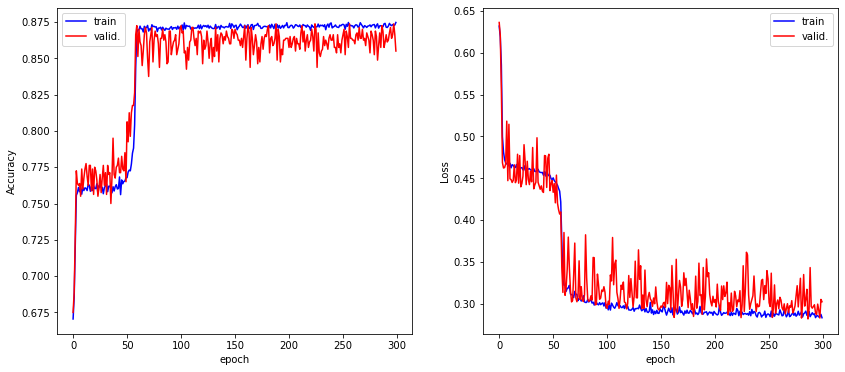

In [29]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(history_augmented.history['accuracy'],label="train",c="b")
ax.plot(history_augmented.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()
ax=AX[1]
ax.plot(history_augmented.history['loss'],label="train",c="b")
ax.plot(history_augmented.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

51 2601
[50. 50.]
82/82 [==============================] - 0s 2ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

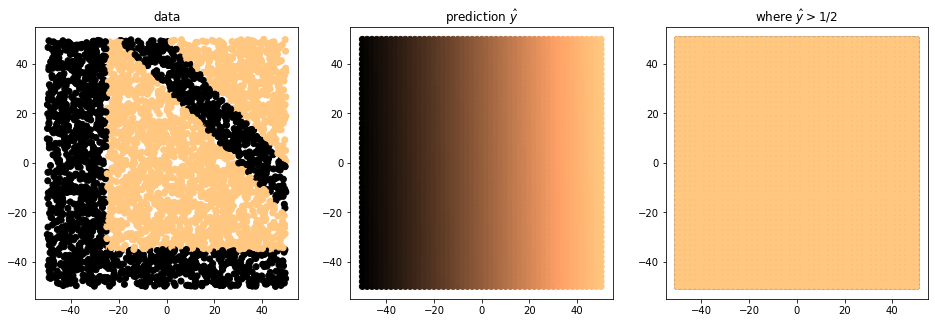

In [30]:
dX = 2
X1 = np.arange(-50,50+dX, dX)
LG = len(X1)
grid = np.zeros((LG*LG,2))
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1
print(len(X1),len(grid))
print(grid[-1])

# RESCALE

grid_r = grid/50

pred = model_augmented.predict(grid_r)

fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y)
ax.set_title("data")

ax=AX[1]
ax.scatter(grid[:,0],grid[:,1],c=pred)
ax.set_title("prediction $\\hat y$")

ax=AX[2]
W1=np.where(pred>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],c="#000000")
ax.scatter(grid[W1,0],grid[W1,1],c="#ffc77f")
ax.set_title("where $\\hat y > 1/2$")
plt.show
plt.show

## Ex.3 Non linearly seperable data

In [31]:
TYPE = 2

x = np.loadtxt(filename("data",TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",TYPE), delimiter=' ')
N = len(x)

# dim. of a sample
L = len(x[0])
print(f'Dimension of a sample{L}')

#training percentage
perc_train = 0.8

N_train = int(perc_train * N)
print(f'data: {N}\ntrain: {N_train}')

Dimension of a sample2
data: 4000
train: 3200


In [32]:
### Split training and test data
(x_train, y_train) = (x[0:N_train],y[0:N_train]) #they are already shuffle 
(x_valid, y_valid) = (x[N_train:],y[N_train:])
print("Train:",len(x_train),"\t Validation:",len(x_valid))

Train: 3200 	 Validation: 800


In [33]:
def Rescale(x):
    return x/50 #the number goes from -50 to 50, so we put them between -1 and 1 to use the non linearity 

x_train = Rescale(x_train)
x_valid = Rescale(x_valid)

<function matplotlib.pyplot.show(close=None, block=None)>

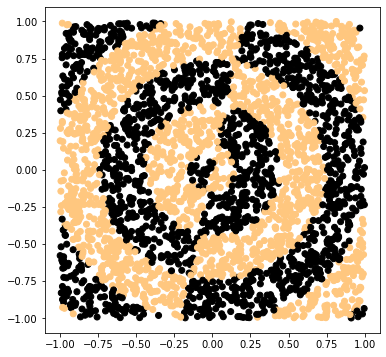

In [34]:
plt.figure(figsize = (6,6))
plt.scatter(x_train[:,0],x_train[:,1],c=y_train)
plt.show

In [35]:
def create_DNN(act_func, neurons): 
    model = Sequential() #empty template of the neural network
    model.add(Dense(L,input_shape=(L,),activation=act_func)) #add a layer dense (all connection) with a ReLu 2 neuron for 2 x_i
    model.add(Dense(units=neurons,activation=act_func))
    model.add(Dense(units=neurons,activation=act_func))
    model.add(Dense(units=neurons,activation=act_func))
    model.add(Dense(units=neurons,activation=act_func))
    model.add(Dropout(0.01)) #it is applied to the last layer, need to be reader in keras documentation 
    model.add(Dense(1,activation='sigmoid'))

    return model 

In [36]:
def compile_model(optimizer='adam', act_func='relu', neurons=20):
    model = create_DNN(act_func, neurons)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])    
    return model

In [37]:
model_nonlinear = compile_model()

In [38]:
nepoch=400
history = model_nonlinear.fit(x_train, y_train,
               epochs = nepoch, batch_size = 50,
               validation_data=(x_valid,y_valid),
               verbose=2)

Epoch 1/400
64/64 - 1s - loss: 0.6933 - accuracy: 0.5028 - val_loss: 0.6929 - val_accuracy: 0.5100 - 1s/epoch - 17ms/step
Epoch 2/400
64/64 - 0s - loss: 0.6920 - accuracy: 0.5381 - val_loss: 0.6926 - val_accuracy: 0.5362 - 254ms/epoch - 4ms/step
Epoch 3/400
64/64 - 0s - loss: 0.6911 - accuracy: 0.5216 - val_loss: 0.6918 - val_accuracy: 0.5387 - 408ms/epoch - 6ms/step
Epoch 4/400
64/64 - 0s - loss: 0.6898 - accuracy: 0.5447 - val_loss: 0.6907 - val_accuracy: 0.5475 - 402ms/epoch - 6ms/step
Epoch 5/400
64/64 - 0s - loss: 0.6890 - accuracy: 0.5409 - val_loss: 0.6890 - val_accuracy: 0.5562 - 226ms/epoch - 4ms/step
Epoch 6/400
64/64 - 0s - loss: 0.6877 - accuracy: 0.5559 - val_loss: 0.6886 - val_accuracy: 0.5487 - 275ms/epoch - 4ms/step
Epoch 7/400
64/64 - 0s - loss: 0.6863 - accuracy: 0.5572 - val_loss: 0.6840 - val_accuracy: 0.5888 - 254ms/epoch - 4ms/step
Epoch 8/400
64/64 - 0s - loss: 0.6831 - accuracy: 0.5738 - val_loss: 0.6813 - val_accuracy: 0.5975 - 252ms/epoch - 4ms/step
Epoch 9/40

Epoch 67/400
64/64 - 0s - loss: 0.4995 - accuracy: 0.7250 - val_loss: 0.4873 - val_accuracy: 0.7563 - 348ms/epoch - 5ms/step
Epoch 68/400
64/64 - 0s - loss: 0.4997 - accuracy: 0.7281 - val_loss: 0.4869 - val_accuracy: 0.7550 - 219ms/epoch - 3ms/step
Epoch 69/400
64/64 - 0s - loss: 0.4960 - accuracy: 0.7275 - val_loss: 0.4875 - val_accuracy: 0.7538 - 290ms/epoch - 5ms/step
Epoch 70/400
64/64 - 0s - loss: 0.4958 - accuracy: 0.7309 - val_loss: 0.4892 - val_accuracy: 0.7513 - 237ms/epoch - 4ms/step
Epoch 71/400
64/64 - 0s - loss: 0.4946 - accuracy: 0.7284 - val_loss: 0.4885 - val_accuracy: 0.7563 - 219ms/epoch - 3ms/step
Epoch 72/400
64/64 - 0s - loss: 0.4957 - accuracy: 0.7291 - val_loss: 0.4882 - val_accuracy: 0.7563 - 337ms/epoch - 5ms/step
Epoch 73/400
64/64 - 0s - loss: 0.4998 - accuracy: 0.7262 - val_loss: 0.4872 - val_accuracy: 0.7487 - 367ms/epoch - 6ms/step
Epoch 74/400
64/64 - 0s - loss: 0.4944 - accuracy: 0.7256 - val_loss: 0.4894 - val_accuracy: 0.7475 - 230ms/epoch - 4ms/step


Epoch 133/400
64/64 - 0s - loss: 0.4880 - accuracy: 0.7297 - val_loss: 0.4803 - val_accuracy: 0.7550 - 290ms/epoch - 5ms/step
Epoch 134/400
64/64 - 0s - loss: 0.4871 - accuracy: 0.7231 - val_loss: 0.4845 - val_accuracy: 0.7475 - 291ms/epoch - 5ms/step
Epoch 135/400
64/64 - 0s - loss: 0.4849 - accuracy: 0.7291 - val_loss: 0.4759 - val_accuracy: 0.7600 - 259ms/epoch - 4ms/step
Epoch 136/400
64/64 - 0s - loss: 0.4898 - accuracy: 0.7306 - val_loss: 0.4851 - val_accuracy: 0.7550 - 314ms/epoch - 5ms/step
Epoch 137/400
64/64 - 0s - loss: 0.4898 - accuracy: 0.7375 - val_loss: 0.4780 - val_accuracy: 0.7600 - 220ms/epoch - 3ms/step
Epoch 138/400
64/64 - 0s - loss: 0.4897 - accuracy: 0.7284 - val_loss: 0.4828 - val_accuracy: 0.7563 - 262ms/epoch - 4ms/step
Epoch 139/400
64/64 - 0s - loss: 0.4900 - accuracy: 0.7316 - val_loss: 0.4865 - val_accuracy: 0.7337 - 243ms/epoch - 4ms/step
Epoch 140/400
64/64 - 0s - loss: 0.4914 - accuracy: 0.7303 - val_loss: 0.4785 - val_accuracy: 0.7525 - 257ms/epoch - 4

64/64 - 0s - loss: 0.4766 - accuracy: 0.7337 - val_loss: 0.4709 - val_accuracy: 0.7513 - 229ms/epoch - 4ms/step
Epoch 199/400
64/64 - 0s - loss: 0.4796 - accuracy: 0.7350 - val_loss: 0.4725 - val_accuracy: 0.7613 - 276ms/epoch - 4ms/step
Epoch 200/400
64/64 - 0s - loss: 0.4823 - accuracy: 0.7344 - val_loss: 0.4689 - val_accuracy: 0.7625 - 224ms/epoch - 3ms/step
Epoch 201/400
64/64 - 0s - loss: 0.4822 - accuracy: 0.7319 - val_loss: 0.4789 - val_accuracy: 0.7500 - 351ms/epoch - 5ms/step
Epoch 202/400
64/64 - 0s - loss: 0.4849 - accuracy: 0.7281 - val_loss: 0.4701 - val_accuracy: 0.7550 - 220ms/epoch - 3ms/step
Epoch 203/400
64/64 - 0s - loss: 0.4789 - accuracy: 0.7341 - val_loss: 0.4767 - val_accuracy: 0.7487 - 288ms/epoch - 4ms/step
Epoch 204/400
64/64 - 0s - loss: 0.4852 - accuracy: 0.7272 - val_loss: 0.4840 - val_accuracy: 0.7462 - 211ms/epoch - 3ms/step
Epoch 205/400
64/64 - 0s - loss: 0.4853 - accuracy: 0.7259 - val_loss: 0.4748 - val_accuracy: 0.7625 - 293ms/epoch - 5ms/step
Epoch 

Epoch 264/400
64/64 - 0s - loss: 0.4657 - accuracy: 0.7384 - val_loss: 0.4461 - val_accuracy: 0.7575 - 205ms/epoch - 3ms/step
Epoch 265/400
64/64 - 0s - loss: 0.4713 - accuracy: 0.7341 - val_loss: 0.4440 - val_accuracy: 0.7525 - 277ms/epoch - 4ms/step
Epoch 266/400
64/64 - 0s - loss: 0.4716 - accuracy: 0.7297 - val_loss: 0.4589 - val_accuracy: 0.7113 - 220ms/epoch - 3ms/step
Epoch 267/400
64/64 - 0s - loss: 0.4682 - accuracy: 0.7334 - val_loss: 0.4459 - val_accuracy: 0.7538 - 318ms/epoch - 5ms/step
Epoch 268/400
64/64 - 0s - loss: 0.4643 - accuracy: 0.7356 - val_loss: 0.4449 - val_accuracy: 0.7538 - 216ms/epoch - 3ms/step
Epoch 269/400
64/64 - 0s - loss: 0.4711 - accuracy: 0.7281 - val_loss: 0.4506 - val_accuracy: 0.7588 - 235ms/epoch - 4ms/step
Epoch 270/400
64/64 - 0s - loss: 0.4657 - accuracy: 0.7347 - val_loss: 0.4442 - val_accuracy: 0.7563 - 216ms/epoch - 3ms/step
Epoch 271/400
64/64 - 0s - loss: 0.4691 - accuracy: 0.7344 - val_loss: 0.4439 - val_accuracy: 0.7625 - 270ms/epoch - 4

64/64 - 0s - loss: 0.4560 - accuracy: 0.7369 - val_loss: 0.4469 - val_accuracy: 0.7513 - 343ms/epoch - 5ms/step
Epoch 330/400
64/64 - 0s - loss: 0.4615 - accuracy: 0.7387 - val_loss: 0.4325 - val_accuracy: 0.7625 - 342ms/epoch - 5ms/step
Epoch 331/400
64/64 - 0s - loss: 0.4577 - accuracy: 0.7369 - val_loss: 0.4320 - val_accuracy: 0.7575 - 278ms/epoch - 4ms/step
Epoch 332/400
64/64 - 0s - loss: 0.4562 - accuracy: 0.7341 - val_loss: 0.4421 - val_accuracy: 0.7550 - 316ms/epoch - 5ms/step
Epoch 333/400
64/64 - 1s - loss: 0.4561 - accuracy: 0.7378 - val_loss: 0.4350 - val_accuracy: 0.7613 - 659ms/epoch - 10ms/step
Epoch 334/400
64/64 - 1s - loss: 0.4596 - accuracy: 0.7316 - val_loss: 0.4332 - val_accuracy: 0.7663 - 588ms/epoch - 9ms/step
Epoch 335/400
64/64 - 0s - loss: 0.4539 - accuracy: 0.7362 - val_loss: 0.4434 - val_accuracy: 0.7588 - 499ms/epoch - 8ms/step
Epoch 336/400
64/64 - 1s - loss: 0.4600 - accuracy: 0.7372 - val_loss: 0.4258 - val_accuracy: 0.7663 - 853ms/epoch - 13ms/step
Epoc

64/64 - 0s - loss: 0.4558 - accuracy: 0.7362 - val_loss: 0.4290 - val_accuracy: 0.7563 - 238ms/epoch - 4ms/step
Epoch 395/400
64/64 - 0s - loss: 0.4535 - accuracy: 0.7372 - val_loss: 0.4354 - val_accuracy: 0.7638 - 274ms/epoch - 4ms/step
Epoch 396/400
64/64 - 0s - loss: 0.4548 - accuracy: 0.7347 - val_loss: 0.4432 - val_accuracy: 0.7538 - 256ms/epoch - 4ms/step
Epoch 397/400
64/64 - 0s - loss: 0.4546 - accuracy: 0.7422 - val_loss: 0.4268 - val_accuracy: 0.7575 - 353ms/epoch - 6ms/step
Epoch 398/400
64/64 - 0s - loss: 0.4544 - accuracy: 0.7397 - val_loss: 0.4511 - val_accuracy: 0.7538 - 233ms/epoch - 4ms/step
Epoch 399/400
64/64 - 0s - loss: 0.4538 - accuracy: 0.7309 - val_loss: 0.4285 - val_accuracy: 0.7600 - 249ms/epoch - 4ms/step
Epoch 400/400
64/64 - 0s - loss: 0.4581 - accuracy: 0.7300 - val_loss: 0.4328 - val_accuracy: 0.7625 - 235ms/epoch - 4ms/step


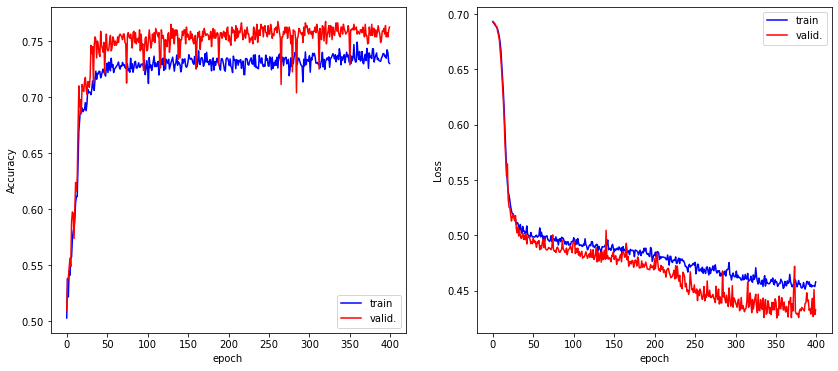

In [39]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))
ax=AX[0]
ax.plot(history.history['accuracy'],label="train",c="b")
ax.plot(history.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()
ax=AX[1]
ax.plot(history.history['loss'],label="train",c="b")
ax.plot(history.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

In [40]:
dX = 2
X1 = np.arange(-50,50+dX, dX)
LG = len(X1)
grid = np.zeros((LG*LG,2))
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1
print(len(X1),len(grid))
print(grid[-1])

# RESCALE

grid_r = grid/50

pred = model_nonlinear.predict(grid_r)

51 2601
[50. 50.]
82/82 [==============================] - 1s 8ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

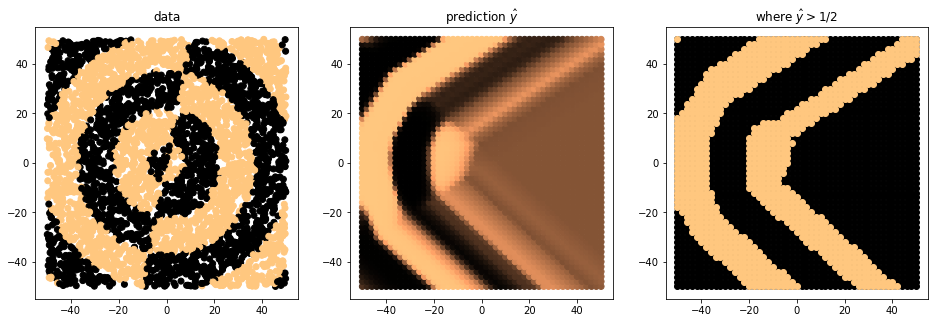

In [41]:
fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y)
ax.set_title("data")

ax=AX[1]
ax.scatter(grid[:,0],grid[:,1],c=pred)
ax.set_title("prediction $\\hat y$")

ax=AX[2]
W1=np.where(pred>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],c="#000000")
ax.scatter(grid[W1,0],grid[W1,1],c="#ffc77f")
ax.set_title("where $\\hat y > 1/2$")

plt.show
plt.show